# Gradient Episodic Memory

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

import pyfiles.GEMLearning as GEMLearning

### Define P-MNIST data loader

In [0]:
class PermutedMNISTDataLoader(torchvision.datasets.MNIST):
    def __init__(self, source='data/mnist_data', train = True, shuffle_seed = None):
        super(PermutedMNISTDataLoader, self).__init__(source, train, download=True)
        
        self.train = train
        self.num_data = 0
        
        if self.train:
            self.permuted_train_data = torch.stack(
                [img.type(dtype=torch.float32).view(-1)[shuffle_seed] / 255.0
                    for img in self.train_data])
            self.num_data = self.permuted_train_data.shape[0]
            
        else:
            self.permuted_test_data = torch.stack(
                [img.type(dtype=torch.float32).view(-1)[shuffle_seed] / 255.0
                    for img in self.test_data])
            self.num_data = self.permuted_test_data.shape[0]
            
            
    def __getitem__(self, index):
        
        if self.train:
            input, label = self.permuted_train_data[index], self.train_labels[index]
        else:
            input, label = self.permuted_test_data[index], self.test_labels[index]
        
        return input, label

    
    def getNumData(self):
        return self.num_data

### Set hyperparameters & get permuted MNIST

In [0]:
batch_size = 64
learning_rate = 1e-3
num_task = 10
criterion = torch.nn.CrossEntropyLoss()
cuda_available = False
if torch.cuda.is_available():
    cuda_available = True

In [0]:
def permute_mnist():
    train_loader = {}
    test_loader = {}
    
    train_data_num = 0
    test_data_num = 0
    
    for i in range(num_task):
        shuffle_seed = np.arange(28*28)
        np.random.shuffle(shuffle_seed)
        
        train_PMNIST_DataLoader = PermutedMNISTDataLoader(train=True, shuffle_seed=shuffle_seed)
        test_PMNIST_DataLoader = PermutedMNISTDataLoader(train=False, shuffle_seed=shuffle_seed)
        
        train_data_num += train_PMNIST_DataLoader.getNumData()
        test_data_num += test_PMNIST_DataLoader.getNumData()
        
        train_loader[i] = torch.utils.data.DataLoader(
                train_PMNIST_DataLoader,
                batch_size=batch_size)
        
        test_loader[i] = torch.utils.data.DataLoader(
                test_PMNIST_DataLoader,
                batch_size=batch_size)
    
    return train_loader, test_loader, int(train_data_num/num_task), int(test_data_num/num_task)

train_loader, test_loader, train_data_num, test_data_num = permute_mnist()

### Define Neural Net

In [0]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        # Always start with inheriting torch.nn.Module
        # Ancestor class of all Neural Net module
        super(NeuralNet, self).__init__()
        # Linear: linear transformation
        fc1 = torch.nn.Linear(28*28, 100)
        fc2 = torch.nn.Linear(100, 100)
        fc3 = torch.nn.Linear(100, 100)
  
        
        self.fc_module = torch.nn.Sequential(
            fc1,
            torch.nn.ReLU(),
            fc2,
            torch.nn.ReLU(),
            fc3
        )
        
        if torch.cuda.is_available():
            self.fc_module = self.fc_module.cuda()

    def forward(self, x):
        return self.fc_module(x)

### Continual Learnig with GEM

In [21]:
memsize_list = [100, 300, 1000, 3000]
avg_acc = {}

for mem_size in memsize_list:
    memsize_acc = []
    net = NeuralNet()
    optim = torch.optim.SGD(net.parameters(), lr=0.1)
    gem = GEMLearning(net = net,
                          tasks = num_task,
                          optim = optim,
                          criterion = criterion,
                          mem_size = mem_size,
                          traindata_len = train_data_num,
                          testdata_len = test_data_num,
                          batch_size = batch_size,
                      margin = 0.5,
                      eps = 0.001)
    
    for i in range(num_task):
        gem.train(train_loader[i], i)
        
        for j in range(i+1):
            gem.eval(test_loader[j], j)
            
        print(gem.R)
        memsize_acc.append(torch.sum(gem.R[i]).item() / (i+1))

    avg_acc[mem_size] = memsize_acc

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)
CrossEntropyLoss()
Memory size:  100


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


[1	100] AVG. loss: 1.667

[1	200] AVG. loss: 0.594

[1	300] AVG. loss: 0.454

[1	400] AVG. loss: 0.366

[1	500] AVG. loss: 0.363

[1	600] AVG. loss: 0.297

[1	700] AVG. loss: 0.290

[1	800] AVG. loss: 0.294

[1	900] AVG. loss: 0.235



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor([[93.0700,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  

[93.06999969482422, 92.08000183105469, 91.64000447591145, 91.1875, 90.88599853515625, 90.18332926432292, 89.81285749162946, 89.63999938964844, 89.50333658854167, 88.86199951171875]
[92.7699966430664, 92.29499816894531, 92.27999877929688, 91.75250244140625, 91.54400634765625, 91.2133280436198, 91.15999930245536, 90.98124694824219, 90.92555745442708, 90.7820068359375]
[92.8499984741211, 92.95500183105469, 92.80999755859375, 92.7550048828125, 92.602001953125, 92.59666951497395, 92.605712890625, 92.57499694824219, 92.47333441840277, 92.44000244140625]
[92.70999908447266, 93.23999786376953, 93.46666463216145, 93.52749633789062, 93.56000366210938, 93.57166544596355, 93.52572195870536, 93.60874938964844, 93.51444498697917, 93.50799560546875]


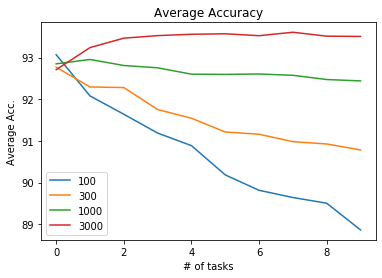

In [27]:
plt.xlabel("# of tasks")
plt.ylabel("Average Acc.")
plt.title("Average Accuracy")

for memsize, acc_list in avg_acc.items():
    x = [i for i in range(10)]
    y = acc_list
    print(y)
    plt.plot(x, y, label=str(memsize))

plt.legend(loc=3)
plt.show()
